In [14]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

['numerical_feature_names', 'overall_slope', 'max_depth', 'max_resistance', 'num_peaks', 'largest_force_drop', 'largest_force_drop_dep', 'largest_force_drop_res', 'curve_shape', 'first_quarter_slope', 'second_quarter_slope', 'third_quarter_slope', 'fourth_quarter_slope', 'depth_mean', 'depth_median', 'depth_variance', 'depth_quartile_1', 'depth_quartile_2', 'depth_quartile_3', 'depth_kurtosis', 'res_mean', 'res_median', 'res_variance', 'res_quartile_1', 'res_quartile_2', 'res_quartile_3', 'res_skew', 'res_kurtosis', 'k_overall', 'k2cm', 'rsquared', 'work2cm', 'Fpeak', 'dpeak']


In [15]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [16]:
ylabel_name = 'marions_ylabels_esd_removed'
data_features = pd.read_csv("data/features.csv")
data_features = data_features[['largest_force_drop', 'res_mean', 'dpeak', 'k2cm', 'overall_slope', ylabel_name]] # 0.7


clustering_features = plotting.extract_numerical_features(data_features)

In [17]:

# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

# Used for Correcting Labels

In [18]:
def find_changed_ylabel_data(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index

def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Nearest Centroid
- Each class is represented by it's centroid, with test sample classified to the class with the nearest centroid

Index([1, 11, 16, 17, 19, 55, 64, 69, 71, 74, 85, 95, 100], dtype='int64')


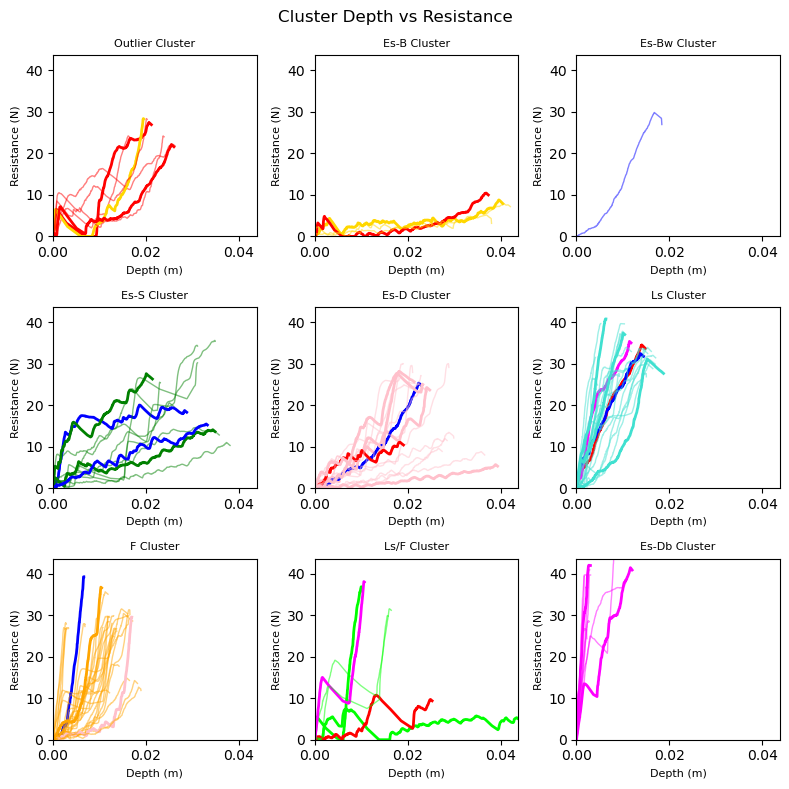

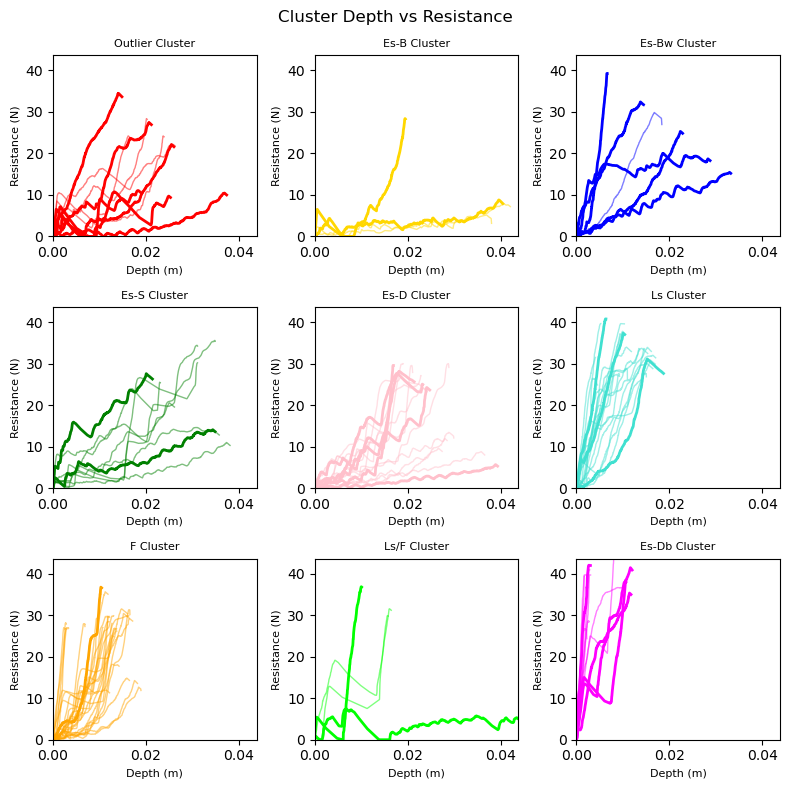

In [19]:
from sklearn.neighbors import NearestCentroid

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
clf = NearestCentroid()
clf.fit(X,y)
predictions = pd.Series(clf.predict(clustering_features.values))

actual = marions_labeled_data[f'{ylabel_name}_nums']
changed_ylabel_idxs = find_changed_ylabel_data(predictions, actual)
print(changed_ylabel_idxs)
corrected_predictions = correct_pseudo_ylabels_to_actual(predictions, actual, changed_ylabel_idxs)
# print(pd.DataFrame({
#     'predicted': predictions,
#     'actual': actual,
#     'corrected_predicted': corrected_predictions,
# }))

plotting.plot_cluster_subolots(predictions, curve_data,
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=corrected_predictions,
                                  bold_idxs=actual.index
                                  )
plotting.plot_cluster_subplots(corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=actual.index)
plotting.plot_pca(clustering_features, predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# K-Nearest-Neighbor
- From the k nearest points, assign query point to the highest frequency label
- Performs better when data is uniformly distributed in feature space (clusters all have similar desnity)

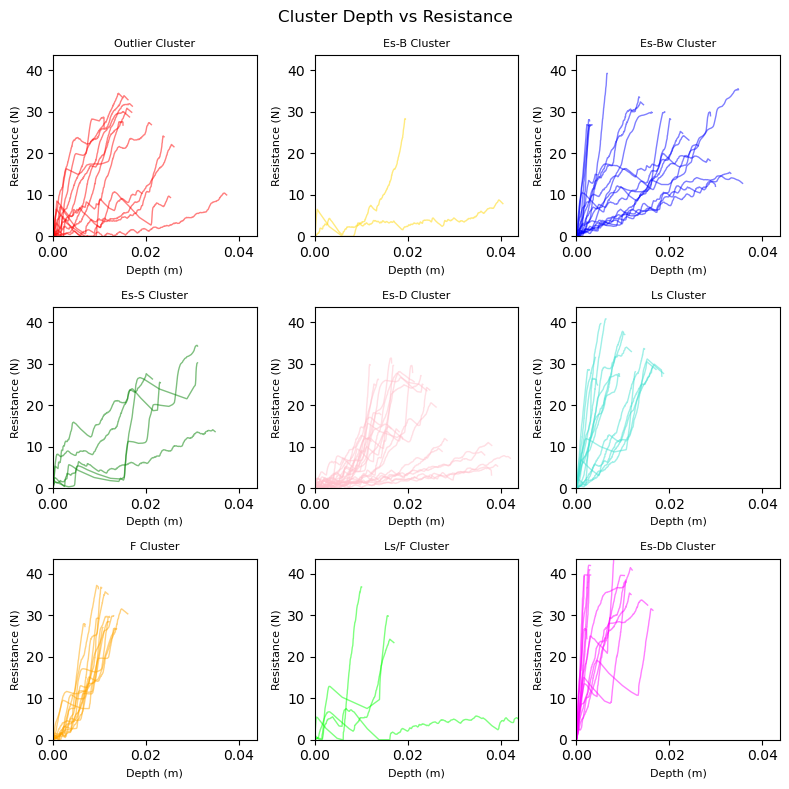

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
predictions = pd.Series(knn.predict(clustering_features.values))


# plotting.plot_cluster_subolots(predictions, curve_data,
#                                   clustering_method="Nearest Centroid", 
#                                   cluster_category_names=list(ylabel_to_cluster_num.keys()),
#                                   pseudo_corrections=corrected_predictions,
#                                   bold_idxs=actual.index
#                                   )
# plotting.plot_cluster_subplots(corrected_predictions, curve_data, 
#                                   clustering_method="Nearest Centroid", 
#                                   cluster_category_names=list(ylabel_to_cluster_num.keys()),
#                                   bold_idxs=actual.index)
# plotting.plot_pca(clustering_features, predictions, 3, 
#                   graph_title=f'',
#                   ylabel_name=ylabel_name,)


plotting.plot_cluster_subplots(predictions, curve_data, 
                                  clustering_method="KNN", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  )
plotting.plot_pca(clustering_features, predictions, 3, 
                  graph_title=f'KNN with k=1 on {ylabel_name}',
                  ylabel_name=ylabel_name,)

# Radius Neighbors Classifier
- Within radius r, assing query point to highest frequency label
- Good for when data isn't uniformly distributed (clusters have different densities)

/home/frankwoods/anaconda3/envs/env3.13/lib/python3.13/site-packages/sklearn/neighbors/_classification.py:864: UserWarning:

Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.



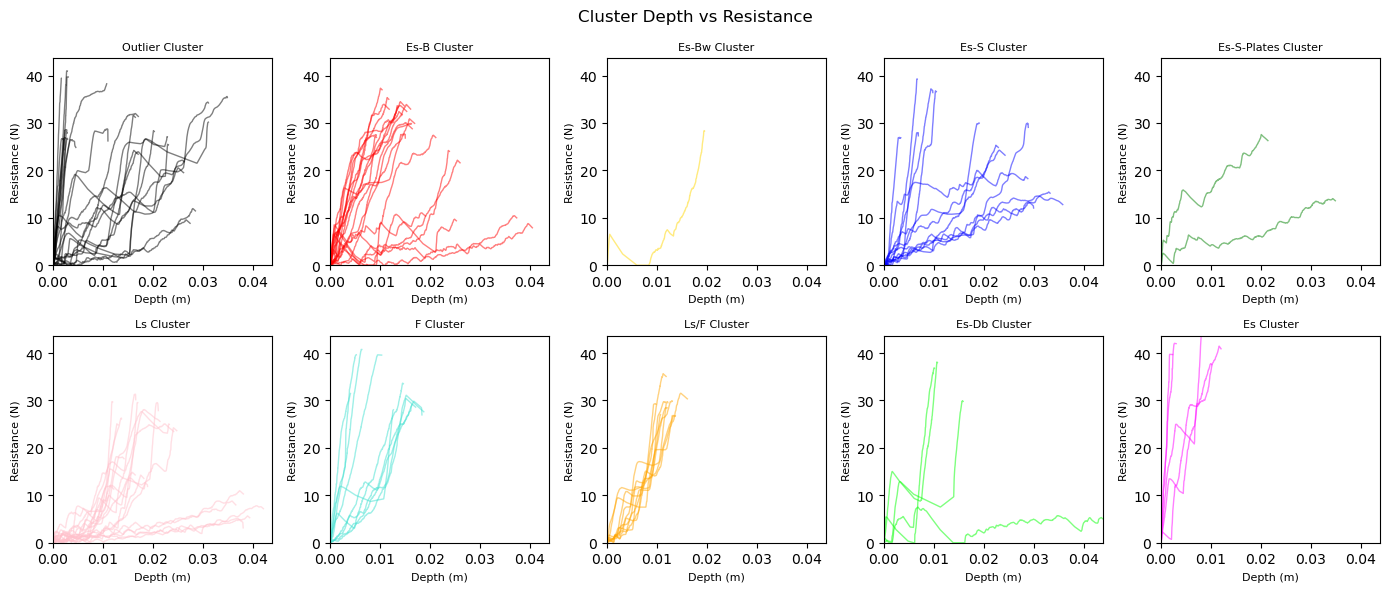

In [21]:
from sklearn.neighbors import RadiusNeighborsClassifier


X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
neigh = RadiusNeighborsClassifier(radius=0.9, outlier_label=-1)
neigh.fit(X,y)
predictions = pd.Series(neigh.predict(clustering_features.values))

plotting.plot_cluster_subplots(predictions, curve_data,  
                                  clustering_method="Radius Neighbors Classifier", 
                                  cluster_category_names={v: k for k, v in ylabel_to_cluster_num.items()},
                                  )
plotting.plot_pca(clustering_features, predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)
